# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

# Some utility functions

In [1]:
def plotList(images, titles=[], shape=None, figsize=None, plot_axis='on'):
    
    N = len(images)
    
    if shape is None:
        shape = (1,N)
    
    rows = shape[0]
    cols = shape[1]
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    for row in range(rows):
        for col in range(cols):
            
            ax = axes[row,col] if rows > 1 and cols > 1 else axes[col]
            
            i = row * cols + col
            if i < N:
                ax.imshow(images[i])
                ax.axis(plot_axis)
                if len(titles) > 0:
                    ax.title.set_text(titles[i])
            else:
                ax.axis('off')    
    return fig

In [2]:
class Camera():
    def __init__(self):
        self.calib_mtx = None
        self.distortion = None
        self.M_bird = np.identity(3)
        self.M_inv  = np.identity(3)
        
        self.src = []
        self.dst = []
    
    def hasCalibration(self):
        return self.calib_mtx is not None
    
    def undistort(self, img):
        return cv2.undistort(img, self.calib_mtx, self.distortion, None, self.calib_mtx) if self.hasCalibration() else img

    def getPerspective(self):
        self.M_p    = cv2.getPerspectiveTransform(self.src, self.dst) if len(self.src) > 0 else np.identity(3)
        self.M_inv  = cv2.getPerspectiveTransform(self.dst, self.src) if len(self.src) > 0 else np.identity(3)
    
    def warpPerspective(self, img):
        if self.M_bird is None:
            return img
        return cv2.warpPerspective(img, self.M_p, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarpPerspective(self, img):
        if self.M_inv is None:
            return img
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# First, I'll compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

patternSize = (9,6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
objp[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

results = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, patternSize,None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, patternSize, corners, ret)
        results.append(img)

In [4]:
_ = plotList(results, shape=(4,4), figsize=(20,10), plot_axis='off')

In [5]:
import pickle

calibration_file = "camera_calib.p"

cam = Camera()

ret, cam.calib_mtx, cam.distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dist_pickle = {'mtx':cam.calib_mtx, 'dist':cam.distortion}

with open(calibration_file, 'wb') as file:
    print('write ' + calibration_file)
    pickle.dump(dist_pickle, file, protocol=pickle.HIGHEST_PROTOCOL)

write camera_calib.p


# Apply a distortion correction to raw images.

read camera_calib.p
mtx:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distortion:
 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


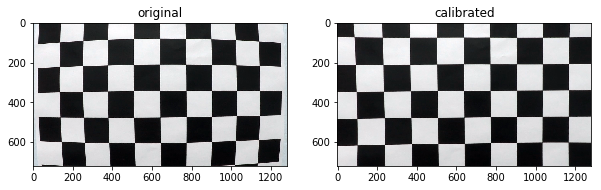

In [6]:
print('read ' + calibration_file)

dist_pickle = pickle.load( open( calibration_file, "rb" ) )
cam.calib_mtx   = dist_pickle["mtx"]
cam.distortion  = dist_pickle["dist"]

print('mtx:\n', cam.calib_mtx)
print('distortion:\n', cam.distortion)

img = cv2.imread(images[0])

fig = plotList(
    images  = [img, cam.undistort(img)],
    titles  = ['original', 'calibrated'],
    figsize = (10,20)
)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
basedir = "test_images/"
test_images = os.listdir(basedir)
test_images = list(map(lambda path: os.path.join(basedir, path), test_images))
for path in test_images:
    print(path)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


In [84]:
test = test_images[2]

## Use color transforms, gradients, etc., to create a thresholded binary image.

## Helper functions

In [85]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def filter_roi(img):
    roi_top = 480
    roi_btm = 30
    h,w = img.shape
    return region_of_interest(img, vertices = np.array( [[[roi_top,h/2+h/12],[w-roi_top,h/2+h/12],[w-roi_btm,h],[roi_btm,h]]], dtype=np.int32 ))

In [86]:
def filter_sobel(gray, dx, dy, thresholds=(20, 100)):
    sobel     = cv2.Sobel(gray, cv2.CV_64F, dx, dy)
    sobel_abs = np.absolute(sobel)
    scaled    = np.uint8(255*sobel_abs/np.max(sobel_abs))
    
    sbinary = np.zeros_like(sobel)
    sbinary[(scaled >= thresholds[0]) & (scaled <= thresholds[1])] = 1
    
    return sbinary

def filter_gradient(gray, kernel_size, thresholds=(100, 255)):
    # gradients in x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # gradient magnitude
    gradient = np.sqrt(sobelx**2 + sobely**2)
    # normalisation
    scale_factor = np.max(gradient)/255 
    gradient = (gradient/scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    sbinary = np.zeros_like(gradient)
    sbinary[(gradient >= thresholds[0]) & (gradient <= thresholds[1])] = 1
    
    return sbinary

def filter_scolor(hls, thresholds=(170,255)):
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= thresholds[0]) & (s_channel <= thresholds[1]) & (l_channel >= 30)] = 1
    return binary

def filter_lcolor(hls, thresholds=(170,255)):
    l_channel = hls[:,:,1]
    binary = np.zeros_like(l_channel)
    binary[(l_channel >= thresholds[0]) & (l_channel <= thresholds[1])] = 1
    return binary

def filter_yellow(rgb, thresholds=(120,120,100)):
    r = rgb[:,:,0]
    g = rgb[:,:,1]
    b = rgb[:,:,2]
    binary = np.zeros_like(r)
    binary[(r >= thresholds[0]) & (g >= thresholds[1]) & (b < thresholds[2])] = 1
    return binary

def filter_white(rgb, thresholds=(200,200,200)):
    r = rgb[:,:,0]
    g = rgb[:,:,1]
    b = rgb[:,:,2]
    binary = np.zeros_like(r)
    binary[(r >= thresholds[0]) & (g >= thresholds[1]) & (b >= thresholds[2])] = 1
    return binary

In [87]:
def binarize_rgb(img, debug=False):
    
    hls         = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #gray        = grayscale(img)
    gray        = hls[:,:,1]
    gray        = gaussian_blur(gray, kernel_size=3)
    #gray       = filter_roi(gray)    
    #sobelx     = filter_sobel(gray, 1, 0, thresholds)
    #sobely     = filter_sobel(gray, 0, 1, thresholds)
    gradient    = filter_gradient(gray, 9)
    scolor_bin  = filter_scolor(hls)
    #lcolor_bin  = filter_lcolor(hls, thresholds=(200, 255))
    yellow_bin  = filter_yellow(img) | filter_white(img)
    
    color = np.dstack(( yellow_bin, gradient, scolor_bin)) * 255
    return color

## Binarisation

In [88]:
import matplotlib.image as mpimg

plt.rcParams["figure.figsize"] = [15,10]

print(test)
img = mpimg.imread(test)

test_images/test1.jpg


In [89]:
#testvideo = VideoFileClip('challenge_video.mp4')
#frames = list(testvideo.iter_frames())
#img = frames[0]

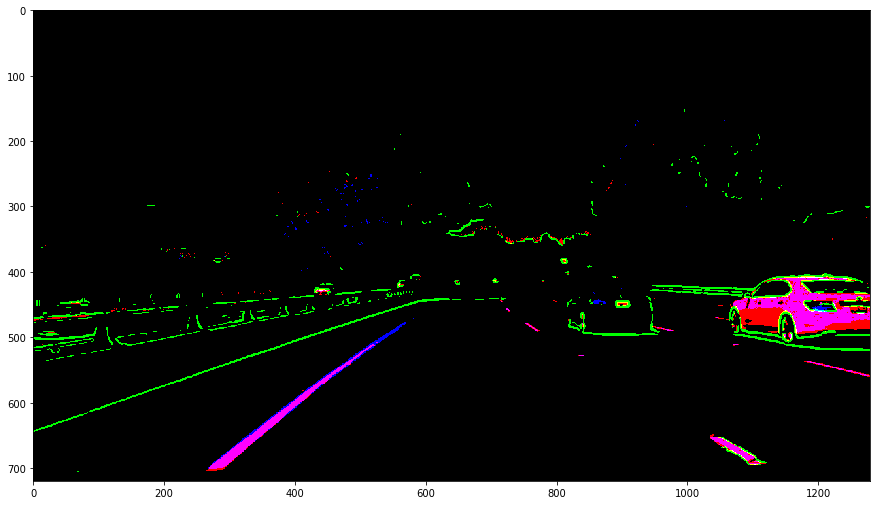

In [90]:
img = cam.undistort(img)
binary = binarize_rgb(img, debug=True)

f = plt.imshow(binary)
_ = cv2.imwrite('examples/binary_combo_example.jpg', binary)

## Apply a perspective transform to rectify binary image ("birds-eye view").

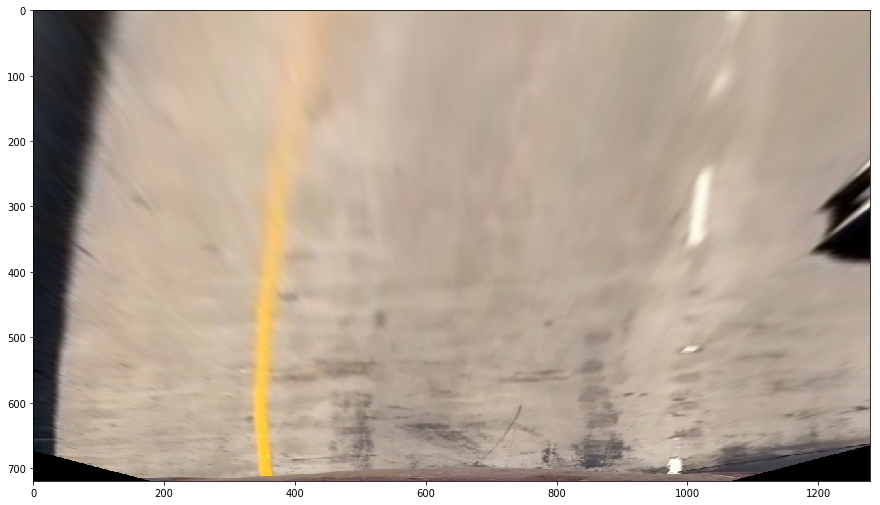

In [91]:
cam.src = np.float32([
    [203-3,   720],
    [585-7,   460],
    [695+10,  460],
    [1127,    720],
])
cam.dst = np.float32([
    [320, 720],
    [320,   0],
    [960,   0],
    [960, 720],
])

cam.getPerspective()
warped = cam.warpPerspective(img)

_ = plt.imshow(warped)

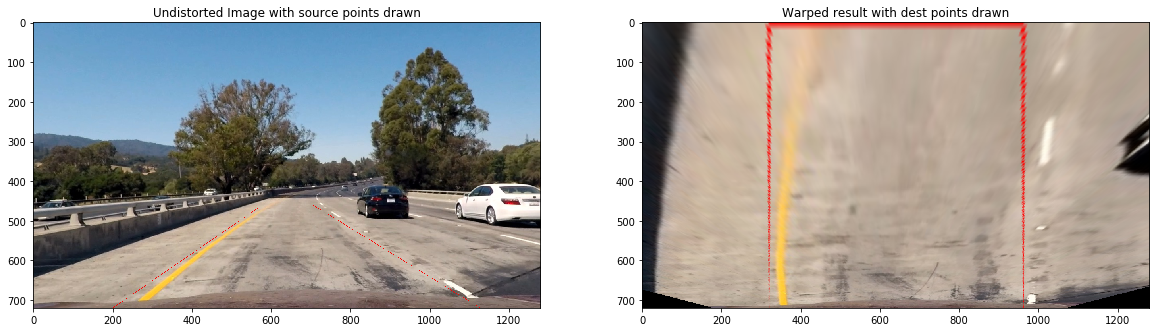

In [92]:
img_orig = img.copy()
img_orig = cv2.polylines(img_orig, np.int32([cam.src]), isClosed=True, color=(255,0,0), thickness=1)
warped2 = cam.warpPerspective(img_orig)

fig = plotList(
    images  = [img_orig, warped2],
    titles  = ['Undistorted Image with source points drawn', 'Warped result with dest points drawn'],
    figsize = (20,10)
)

fig.savefig('examples/warped_straight_lines.jpg')

## Detect lane pixels and fit to find the lane boundary.

In [93]:
lines_rgb = binarize_rgb(warped, debug=False)
lines = np.zeros((lines_rgb.shape[0], lines_rgb.shape[1], 1), dtype=np.uint8)
lines = lines_rgb[:,:,0] | lines_rgb[:,:,1] | lines_rgb[:,:,2]
_ = plt.imshow(lines_rgb)

## Determine the curvature of the lane and vehicle position with respect to center.

In [94]:
histogram = np.sum(lines[lines.shape[0]//4:,:], axis=0)
plt.plot(histogram)

In [95]:
def fitPolyLines(binary_warped, margin = 100):
    
    # Note, I had 
    v_roi = binary_warped.shape[0]//4
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[v_roi:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#    print(leftx[0], leftx[len(leftx)-1], len(leftx))
#    print(lefty[0], lefty[len(lefty)-1], len(lefty))
    
    return left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty
#    return left, right

In [96]:
margin = 100
left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = fitPolyLines(lines, margin)

In [97]:
binary_warped = lines

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds],  nonzerox[left_lane_inds]]  = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('examples/color_fit_lines.jpg')

In [98]:
def trackLanes(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty

left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = trackLanes(binary_warped, left_fit, right_fit)


## sliding window approach

In [99]:
# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')

warped = binary_warped

# window settings
window_width = 50
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
#window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

I don't like it

In [100]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [101]:
def draw_road(binary_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('examples/color_fit_lines.jpg')

draw_road(binary_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)

## Warp the detected lane boundaries back onto the original image.

In [102]:
def drawUnwarped(image, warped, left_fit, right_fit, Minv):
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

result = drawUnwarped(img, binary_warped, left_fit, right_fit, cam.M_inv)
plt.imshow(result)
_ = cv2.imwrite('examples/example_output.jpg', cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [103]:
def line_metrics(image, left_fit, right_fit):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # define y-range in image coordinates
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # simple version in pixel units
    #left_curverad  = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #return left_curverad, right_curverad
    
    # Get curve x-coordinates for each y coordinate
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # estimate line width and vehicle offset
    h,w = image.shape[0],image.shape[1]
    lane_width   = right_fitx[h-1] - left_fitx[h-1]
    lane_centerx = (left_fitx[h-1] + right_fitx[h-1])/2
    img_centerx  = w/2
    
    # redefine conversion based on measured lane width
    xm_per_pix = 3.7/lane_width # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix,  2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #mean_curverad  = (left_curverad + right_curverad)/2
    
    offset = (img_centerx-lane_centerx)*xm_per_pix
    
    return left_curverad, right_curverad, offset

radius_l, radius_r, offset = line_metrics(img, left_fit, right_fit)

print('radius: {:.2f}m, offset: {:.2f}m'.format((radius_l+radius_r)/2, offset))

radius: 783.37m, offset: -0.19m


In [104]:
def drawFinalImage(img, binary_warped, line_l, line_r, cam):
    result = drawUnwarped(img, binary_warped, line_l.best_fit, line_r.best_fit, cam.M_inv)
    
    cv2.putText(result,
        'Radius of Curvature = {:.2f}(m)'.format( line_l.radius_of_curvature ),
        org=(50, 50),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(255,255,255),
        thickness=2)
    
    hint = 'left' if line_l.line_base_pos < 0 else 'right'
    cv2.putText(result,
        'Vehicle is {:.2f}m {} of center'.format(line_l.line_base_pos, hint),
        org=(50,100),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(255,255,255),
        thickness=2)
    
    return result

line_l = Line()
line_l.best_fit = left_fit
line_l.radius_of_curvature = radius_l
line_l.line_base_pos = offset

line_r = Line()
line_r.best_fit = right_fit
line_r.radius_of_curvature = radius_r
line_r.line_base_pos = offset

result = drawFinalImage(img, binary_warped, line_l, line_r, cam)
plt.imshow(result)
_ = cv2.imwrite('examples/example_output.jpg', cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

### Define the whole pipeline

In [105]:
class Curve():
    def __init__(self, line_fit=[0,0,0]):
        #self.coefficients = np.array([line_fit[0],line_fit[1],line_fit[1]], dtype='float')
        self.coefficients = line_fit
    
    def getX(self, y):
        return self.coefficients[0]*y**2 + self.coefficients[1]*y + self.coefficients[2]
    
    def getRadius(self, y):
        return ((1 + (2*self.coefficients[0]*y + self.coefficients[1])**2)**1.5) / np.absolute(2*self.coefficients[0])

# I didn't feel like this was useful. For example, between two consecutive frames the coefficients can change quite a bit, including sign change.
# I don't think the coefficients behave linear and also I cannot compare left and right coefficients simply like that.
# The initial idea was that due to parallelism the coefficients should be related too, but I don't know how that would translate to the coefficient space.
def lines_are_similar(line1, line2):
    return abs(line1[0]-line2[0]) < 0.001 and abs(line1[1]-line2[1]) < 1.0 and abs(line1[2]-line2[2]) < 100

def lines_are_parallel(image, left_fit, right_fit):
    # define y-range in image coordinates
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # Get curve x-coordinates for each y coordinate
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    mean_distance = np.mean(np.abs(left_fitx-right_fitx))
    base_distance = abs(left_fitx[int(y_eval)]-right_fitx[int(y_eval)])
    
    #print(base_distance, mean_distance)
    
    # allow 10% deviation
    return abs(mean_distance - base_distance) < base_distance*0.1


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.clear()
    
    def clear(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
        # keep last N
        self.N = 10
        # clear counter
        self.counter = 0

#    This didn't make sense in the end becaues I forgot that 
#    def addHypothesis(self, curve_left, curve_right):
#               
#        if not lines_are_similar(curve_left.coefficients, curve_right.coefficients):
#            # If the estimated left and right line are not similar,
#            # then we don't have a stable new hypothesis
#            
#            if not self.detected:
#                return
#            else:
#                # Even if the left and right lines are not similar,
#                # if we have a prior estimate we can compare the left and right
#                # lines individually and update if either the left or the right
#                # is similar to the prior
#                
#                if lines_are_similar(self.best_fit, curve_left.coefficients):
#                    update(curve_left.coefficients)
#                elif lines_are_similar(self.best_fit, curve_right.coefficients):
#                    update(curve_right.coefficients)
#                else:
#                    checkClear()
#                    return
#        else:
#            average = (curve_left.coefficients + curve_right.coefficients)/2
#            update(Curve(average))
    
    def maybeReset(self):
        self.counter += 1
        if self.counter > 30:
            self.clear()
    
    def update(self, new_curve, plotx, ploty):
        
        yeval = np.array([719], dtype=np.float32)
        ym_per_pix = 30/720  # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        if not self.detected:
            #print('new detection')
            self.detected = True
            self.current_fit = [new_curve.coefficients]
        elif len(self.recent_xfitted) == self.N:
            self.recent_xfitted.pop(0)
            self.current_fit.pop(0)
        
        xpos = new_curve.getX(yeval)[0]
        self.recent_xfitted.append(xpos)
        self.bestx = np.mean(self.recent_xfitted)
        self.current_fit.append(new_curve.coefficients)
        self.best_fit = np.mean(self.current_fit,axis=0)
        
        # debug
        #self.best_fit = new_curve.coefficients
        #print(self.best_fit)
        #print(self.current_fit)
        #print(self.best_fit)
        
        #self.radius_of_curvature = Curve(self.best_fit).getRadius(yeval*ym_per_pix)[0]
        #self.line_base_pos = self.bestx
        
        # I don't know what the diffs would be useful for
        #self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = plotx  
        #y values for detected line pixels
        self.ally = ploty
        
        #self.detected = False



class Scene():
    def __init__(self):
        self.line_l = Line()
        self.line_r = Line()


def process_image(img, cam, scene):
    
    h,w = img.shape[:2]
    
    minimum, maximum = np.min(img), np.max(img)
    
    img         = ( (img.astype(np.float32) - minimum) / (maximum-minimum) * 255 ).astype(np.uint8)
    
    img         = cam.undistort(img)
    warped      = cam.warpPerspective(img)
    bin_warped3 = binarize_rgb(warped)
    bin_warped  = bin_warped3[:,:,0] | bin_warped3[:,:,1] | bin_warped3[:,:,2]
    
    use_tracker = False
    if use_tracker and scene.line_l.detected and scene.line_r.detected:
        left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = trackLanes(bin_warped, scene.line_l.best_fit, scene.line_r.best_fit)
    else:
        left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = fitPolyLines(bin_warped, margin=100)
    
    curve_l = Curve(left_fit)
    curve_r = Curve(right_fit)
    
    ymax = np.array([h-1], dtype=np.float32)
    lane_width = abs(curve_l.getX(ymax)-curve_r.getX(ymax))
    
    #print('lane_width', lane_width)
    
    #radius_l, radius_r, offset = line_metrics(bin_warped, scene.line_l.best_fit, scene.line_r.best_fit)
    #if not lines_are_similar(left_fit, right_fit):
    #if abs(lane_width - 700) > 100:
        # TODO: look for backup solutions
    #    scene.line_l.maybeReset()
    #    scene.line_r.maybeReset()
    #    return img
    #else:
    #if True:
    
    
    
#    print('detected?',scene.line_l.detected)
#    print('parallel?',lines_are_parallel(img, curve_l.coefficients, curve_r.coefficients))
    if not scene.line_l.detected and not scene.line_r.detected:
        # initialise
        scene.line_l.update(curve_l, leftx, lefty)
        scene.line_r.update(curve_r, leftx, lefty)
    elif lines_are_parallel(img, curve_l.coefficients, curve_r.coefficients):
        # update only if two parallel lines have been estimated
        scene.line_l.update(curve_l, leftx, lefty)
        scene.line_r.update(curve_r, leftx, lefty)
    
    radius_l, radius_r, offset = line_metrics(bin_warped, scene.line_l.best_fit, scene.line_r.best_fit)
    scene.line_l.radius_of_curvature = scene.line_r.radius_of_curvature = radius_l
    scene.line_l.line_base_pos = scene.line_r.line_base_pos = offset

    result = drawFinalImage(img, bin_warped, scene.line_l, scene.line_r, cam)
    
    return result

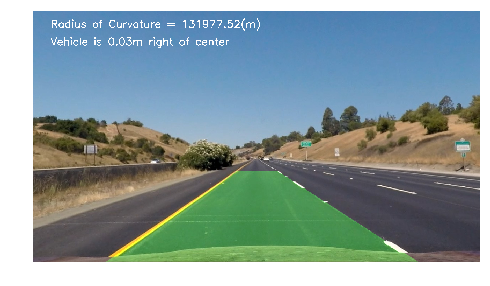

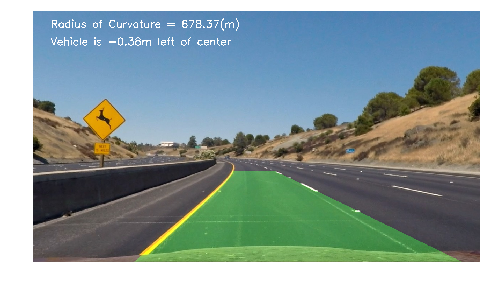

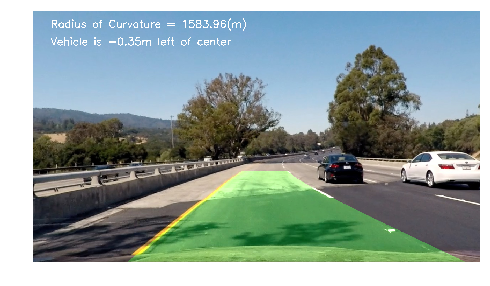

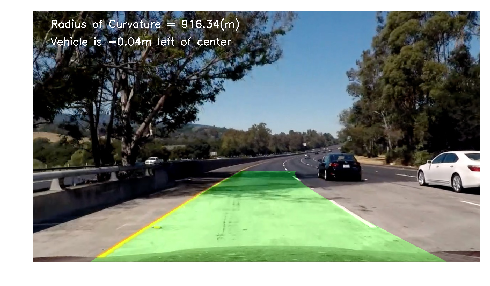

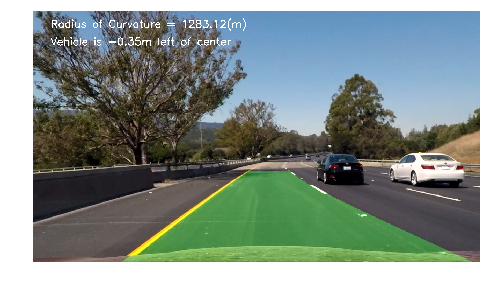

In [106]:
test_results = []
for path in test_images:
    scene = Scene()
    img = mpimg.imread(path)
    processed = process_image(img, cam, scene)
    cv2.imwrite(path.replace('test_images','output_images'), cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    test_results.append(processed)

plt.rcParams["figure.figsize"] = [8,5]

N = len(test_results)
for i in range(N):
    plt.figure()
    plt.imshow(test_results[i])
    plt.axis('off')

In [107]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

from functools import partial

try:
    os.mkdir('test_videos_output')
except:
    pass

In [108]:
def processVideo(name, out, f_process):
    video = VideoFileClip(name)
    video_clip = video.fl_image(f_process) #NOTE: this function expects color images!!
    %time video_clip.write_videofile(out, audio=False)

In [34]:
scene = Scene()
process = partial(process_image,cam=cam,scene=scene)
processVideo("project_video.mp4", 'test_videos_output/project_video.mp4',process)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:50<00:00,  8.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 3min 28s, sys: 37.6 s, total: 4min 6s
Wall time: 2min 51s


In [35]:
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/project_video.mp4'))

In [36]:
scene = Scene()
process = partial(process_image,cam=cam,scene=scene)
processVideo("challenge_video.mp4", 'test_videos_output/challenge_video.mp4',process)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [00:56<00:00,  9.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 1min 14s, sys: 9.7 s, total: 1min 24s
Wall time: 57.4 s


In [37]:
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/challenge_video.mp4'))

In [63]:
scene = Scene()
process = partial(process_image,cam=cam,scene=scene)
processVideo("harder_challenge_video.mp4", 'test_videos_output/harder_challenge_video.mp4',process)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:05<00:00,  7.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 3min 40s, sys: 36.5 s, total: 4min 16s
Wall time: 3min 6s


In [64]:
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/harder_challenge_video.mp4'))